## Step1. 검증용 데이터셋 준비

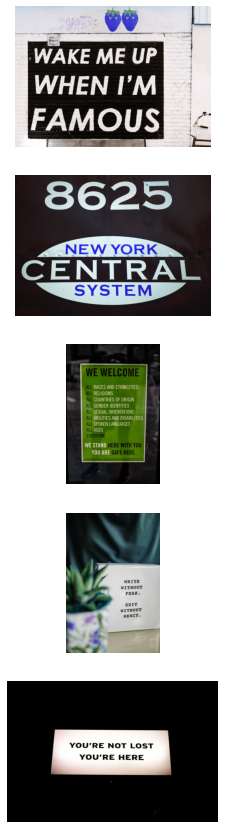

In [87]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont


image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

def url_to_image(url):
    image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    image = Image.fromarray(image)
    return image

plt.figure(figsize=(10, 15))
for i, url in enumerate(image_urls):
    image = url_to_image(url)
    plt.subplot(len(image_urls), 1, i+1)
    plt.imshow(image)
    plt.axis("off")

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### Google OCR API

In [81]:
def get_google_ocr_result(image):
    from google.cloud import vision
    import io
    import os
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

    client = vision.ImageAnnotatorClient()

    # with io.open(image_urls[0], 'rb') as image_file:
    #     content = image_file.read()
    output = io.BytesIO()
    image.save(output, format='JPEG')
    image = vision.Image(content=output.getvalue())

    response = client.text_detection(image=image)
    texts = response.text_annotations
    return texts

In [88]:
def pil_draw_rect_with_label(image, point1, point2, text):
    draw = ImageDraw.Draw(image)
    draw.rectangle((point1, point2), outline=(0, 0, 255), width=3)

    x1, y1 = point1
    imageFont = ImageFont.load_default()
    text_width, text_height = imageFont.getsize(text) 
    draw.rectangle(((x1, y1 - text_height), (x1 + text_width, y1)), fill=(0, 0, 255)) #채워진 사각형
    draw.text((x1, y1 - text_height), text, font=imageFont, fill=(255, 0, 0))
    print(text)
    return image

(51, 136) (471, 411)
WAKE ME UP
WHEN I'M
FAMOUS

(64, 138) (245, 188)
WAKE
(265, 138) (359, 188)
ME
(383, 136) (463, 188)
UP
(66, 225) (305, 291)
WHEN
(336, 225) (459, 290)
I'M
(52, 332) (470, 411)
FAMOUS


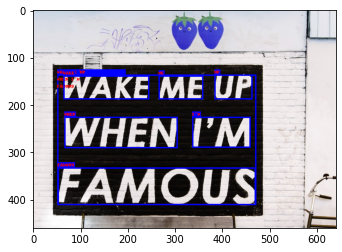

(22, 17) (605, 393)
8625
NEW YORK
CENTRAL
SYSTEM

(97, 22) (512, 111)
8625
(165, 226) (299, 264)
NEW
(312, 222) (475, 263)
YORK
(22, 277) (605, 350)
CENTRAL
(194, 358) (445, 393)
SYSTEM


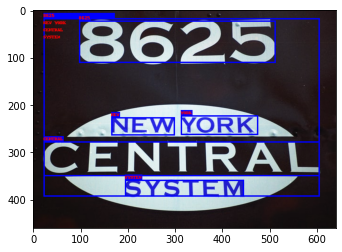

(214, 288) (881, 1339)
WE WELCOME
ALL RACES AND ETHNICITIES
ALL RELIGIONS
ALL COUNTRIES OF ORIGIN
ALL GENDER IDENTITIES
ALL SEXUAL ORIENTATIONS
ALL ABILITIES AND DISABILITIES
ALL SPOKEN LANGUAGES
ALL AGES
EVERYONE.
WE STAND HERE WITH YOU
YOU ARE SAFE HERE
* Content adapted from the original "We Welcome" sign created by IPRC members Lisa Mangum and Jason Levian

(228, 288) (362, 384)
WE
(396, 289) (834, 387)
WELCOME
(214, 474) (313, 533)
ALL
(320, 482) (453, 529)
RACES
(470, 483) (553, 527)
AND
(574, 483) (825, 528)
ETHNICITIES
(215, 552) (306, 606)
ALL
(320, 556) (537, 600)
RELIGIONS
(216, 624) (307, 678)
ALL
(319, 628) (553, 671)
COUNTRIES
(585, 624) (646, 678)
OF
(639, 628) (777, 671)
ORIGIN
(217, 694) (309, 749)
ALL
(320, 699) (485, 742)
GENDER
(507, 699) (724, 741)
IDENTITIES
(218, 765) (309, 819)
ALL
(320, 769) (474, 812)
SEXUAL
(492, 769) (780, 812)
ORIENTATIONS
(216, 832) (315, 891)
ALL
(320, 840) (509, 883)
ABILITIES
(526, 840) (605, 881)
AND
(628, 840) (881, 881)
DISABILITIES


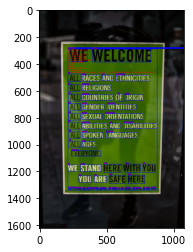

(626, 781) (876, 1569)
WRITE
WITHOUT
FEAR.
EDIT
WITHOUT
MERCY.
NEECA

(669, 785) (842, 814)
WRITE
(630, 855) (876, 881)
WITHOUT
(684, 921) (844, 948)
FEAR.
(681, 1051) (816, 1077)
EDIT
(626, 1120) (866, 1138)
WITHOUT
(659, 1183) (854, 1199)
MERCY.
(646, 1537) (813, 1556)
NEECA


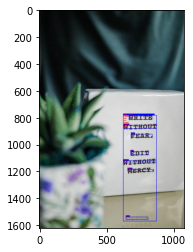

(320, 313) (748, 403)
YOU'RE NOT LOST
YOU'RE HERE

(320, 316) (495, 342)
YOU'RE
(514, 313) (623, 349)
NOT
(632, 318) (748, 344)
LOST
(371, 375) (549, 403)
YOU'RE
(572, 376) (699, 403)
HERE


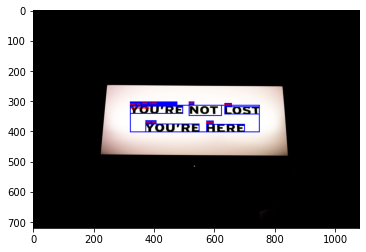

In [116]:
for i, url in enumerate(image_urls):
    image = url_to_image(url)
    results = get_google_ocr_result(image)
    for result in results:
        start = (result.bounding_poly.vertices[0].x, result.bounding_poly.vertices[0].y)
        end = (result.bounding_poly.vertices[2].x, result.bounding_poly.vertices[2].y)
        print(start, end)
        image = pil_draw_rect_with_label(image, start, end, result.description)
        
    plt.imshow(image)
    plt.show()

### keras-ocr

In [90]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [91]:
images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


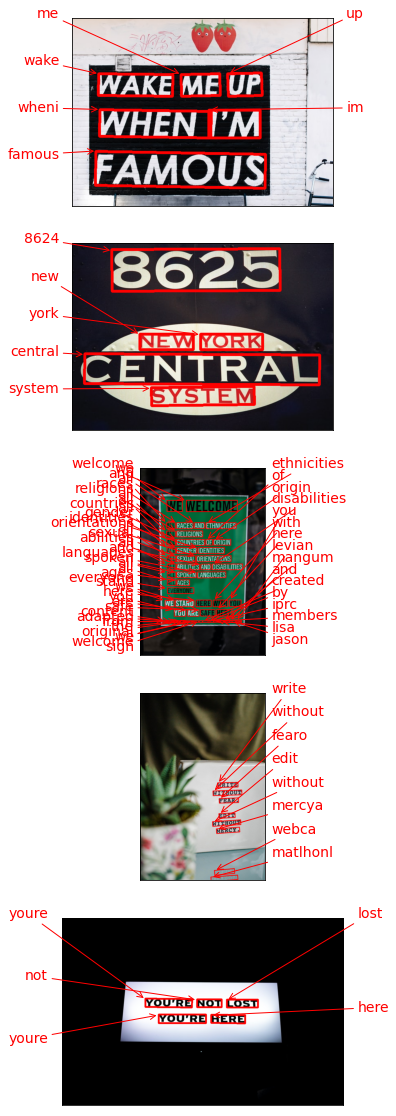

In [92]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

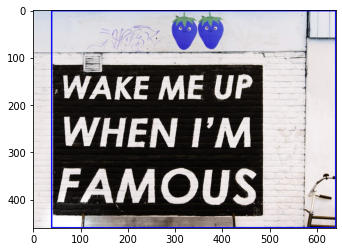

8625
NEw
(oq


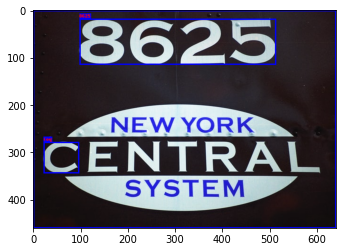

COUNTRIES
OF
ORIGIN
SEXUAL
ORIENTATIONS
ABILITIES
AND
DISABILITIES
SPOKEN
LANGUAGES
AGES
YOU
ARE



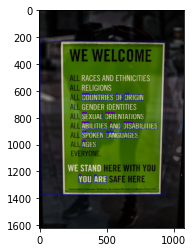

WRITE
WITHOUT
FEAR.
EDIT
WITHOUT
MERCY.



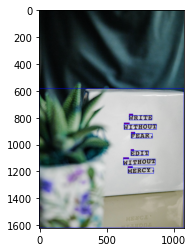

YOU'RE
NOT
LOST
YOU'RE
HERE



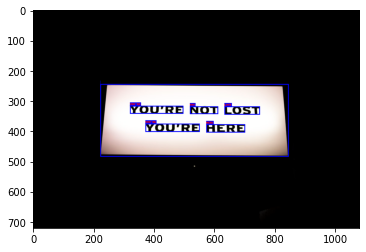

In [132]:
import pytesseract
from pytesseract import Output


for i, url in enumerate(image_urls):
    image = url_to_image(url)
    
    d = pytesseract.image_to_data(image, output_type=Output.DICT)
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            start = (x, y)
            end = (x+w, y+h)
            text = "".join([c if ord(c) < 128 else "" for c in d['text'][i]]).strip()
            image = pil_draw_rect_with_label(image, start, end, text)

    plt.imshow(image)
    plt.show()

## 결론

의외로 Tesseract가 마지막 2개의 사진에서 가장 좋은 결과를 가지고 왔다. 하지만 일반적인 경우 keras-ocr, Google OCR API가 좋은 결과를 가져다 주었다. Google OCR API에서 나온 결과를 Pillow 의 Draw를 이용해서 keras-ocr의 시각화를 따라해보려 시도하였지만 깔끔하게 그리진 못했다. 전체적으로 Keras-OCR의 결과는 훌륭하고 시각화까지 제공하므로 혹시 추후에 OCR을 사용하게 된다면 Keras-OCR을 사용할 것이다.